In [60]:
import numpy as np

from emukit.test_functions.multi_fidelity import multi_fidelity_hartmann_3d
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import LatinDesign

from sklearn.metrics import mean_squared_error, r2_score

In [61]:
from collections import namedtuple

Function = namedtuple('Function', ['name', 'y_scale', 'noise_level', 'do_x_scaling', 'num_data', 'fcn'])


hartmann_3d = Function(name='hartmann', y_scale=1, noise_level=[0., 0., 0.], do_x_scaling=True, num_data=[80, 40, 20], 
                    fcn=multi_fidelity_hartmann_3d)


In [62]:
def generate_data(fcn_tuple, n_test_points):
    """
    Generates train and test data for
    """
    
    # A different definition of the parameter space for the branin function was used in the paper
    if fcn_tuple.name == 'branin':
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace([ContinuousParameter('x1', -5., 0.), ContinuousParameter('x2', 10., 15.)])
    else:
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace(space._parameters[:-1])
    
    do_x_scaling = fcn_tuple.do_x_scaling
    
    
    # Generate training data
    
    latin = LatinDesign(new_space)
    X = [latin.get_samples(n) for n in fcn_tuple.num_data]
    
    # Scale X if required
    if do_x_scaling:
        scalings = X[0].std(axis=0)
    else:
        scalings = np.ones(X[0].shape[1])
        
    for x in X:
        x /= scalings
    
    Y = []
    for i, x in enumerate(X):
        Y.append(fcn.f[i](x * scalings))
    
    y_scale = fcn_tuple.y_scale
    
    # scale y and add noise if required
    noise_levels = fcn_tuple.noise_level
    if any([n > 0 for n in noise_levels]):
        for y, std_noise in zip(Y, noise_levels):
            y /= y_scale + std_noise * np.random.randn(y.shape[0], 1)
    
    # Generate test data
    x_test = latin.get_samples(n_test_points)
    x_test /= scalings
    y_test = fcn.f[-1](x_test * scalings)
    y_test /= y_scale

    i_highest_fidelity = (len(fcn_tuple.num_data) - 1) * np.ones((x_test.shape[0], 1))
    x_test = np.concatenate([x_test, i_highest_fidelity], axis=1)
    print(X[1].shape)
    return x_test, y_test, X, Y

In [63]:
def calculate_metrics(y_test, y_mean_prediction, y_var_prediction):
    # R2
    r2 = r2_score(y_test, y_mean_prediction)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_mean_prediction))
    # Test log likelihood
    mnll = -np.sum(scipy.stats.norm.logpdf(y_test, loc=y_mean_prediction, scale=np.sqrt(y_var_prediction)))/len(y_test)
    return {'r2': r2, 'rmse': rmse, 'mnll': mnll}

In [64]:
np.random.seed(123)

x_test, y_test, X, Y = generate_data(hartmann_3d, 1000)

(40, 3)


In [65]:
X[0].shape, Y[0].shape

((80, 3), (80, 1))

In [66]:
X[1].shape, Y[1].shape

((40, 3), (40, 1))

In [67]:
X[2].shape, Y[2].shape

((20, 3), (20, 1))

In [68]:
x_test.shape, y_test.shape

((1000, 4), (1000, 1))

## Introduce AR1 model and fit all three fidelities of data

In [69]:
from emukit.examples.multi_fidelity_dgp.baseline_model_wrappers import LinearAutoRegressiveModel

m1 =  LinearAutoRegressiveModel(X, Y)
m1.optimize()

Optimization restart 1/10, f = -147.7311847422601
Optimization restart 2/10, f = -144.6298819171123
Optimization restart 3/10, f = -147.72927292782396
Optimization restart 4/10, f = -149.60905814032515
Optimization restart 5/10, f = -150.28486257193777
Optimization restart 6/10, f = -150.28459444747887
Optimization restart 7/10, f = -149.61242421578999
Optimization restart 8/10, f = -150.28169169116074
Optimization restart 9/10, f = -150.25866622972805
Optimization restart 10/10, f = -147.73055998862884
Optimization restart 1/10, f = -150.52703611067443
Optimization restart 2/10, f = -150.52805127319715
Optimization restart 3/10, f = -150.52069972493757
Optimization restart 4/10, f = -149.7978201842871
Optimization restart 5/10, f = -135.70409255418127
Optimization restart 6/10, f = -137.3083017421278
Optimization restart 7/10, f = -147.96373588802692


 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 8/10, f = -135.3204693692221
Optimization restart 9/10, f = -150.33524948833164
Optimization restart 10/10, f = -145.18242422034055


In [70]:
print(m1)

In [71]:
y_mean, y_var = m1.predict(x_test)

import scipy.stats

print(calculate_metrics(y_test, y_mean, y_var))

{'r2': 0.9981412342035538, 'rmse': 0.040520455931103275, 'mnll': -1.8063028336946734}


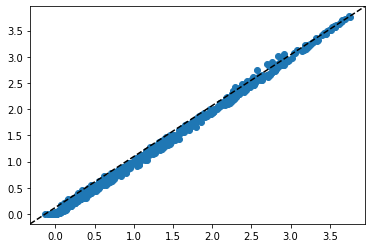

In [72]:
import matplotlib.pyplot as plt

plt.scatter(y_mean,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()

## To set up the data in three-layer structure
### Cheap data, expensive data, high data

In [73]:
X_branin_cheap = X[0]
X_branin_expensive = X[1]
X_branin_high = X[2]

y_branin_cheap = Y[0]
y_branin_expensive = Y[1]
y_branin_high = Y[2]

import GPy
from GPy.kern import Kern
from GPy import Param, Model

m2 = GPy.models.GPRegression(X_branin_cheap, y_branin_cheap)
m2.optimize()

In [74]:
m2.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 34.55533884662158
Optimization restart 2/10, f = 34.55533898456843
Optimization restart 3/10, f = 34.555343344375515
Optimization restart 4/10, f = 34.55533884388633
Optimization restart 5/10, f = 34.55534001844444
Optimization restart 6/10, f = 34.55533894471999
Optimization restart 7/10, f = 34.55533893306482
Optimization restart 8/10, f = 34.55533902856162
Optimization restart 9/10, f = 34.555340722291604
Optimization restart 10/10, f = 34.55533884286709


In [75]:
print(m2)


Name : GP regression
Objective : 34.55533884286709
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      1.0419730894176773  |      +ve      |        
  rbf.lengthscale          |      0.8820393818512069  |      +ve      |        
  Gaussian_noise.variance  |  1.1536121031968866e-10  |      +ve      |        


In [76]:
m2.kern.variance[0], m2.kern.lengthscale[0]

(1.0419730894176773, 0.8820393818512069)

### predicting the expensive data using gp trained with cheap data

In [77]:
muA, vA = m2.predict(X_branin_expensive, full_cov = True)

### Set up the kernel matrix using posterior mean and covariance in mu_A and cov_A

In [78]:
from MFRBF import MFRBF

kMF_A = MFRBF(input_dim=X_branin_expensive.shape[1], variance = 5, lengthscale = 1, mu = muA, v=vA)

In [79]:
kRBF_A = GPy.kern.RBF(input_dim = X_branin_expensive.shape[1])

k_A = kMF_A * kRBF_A

#k_A = kMF_A

m_A = GPy.models.GPRegression(X_branin_expensive, y_branin_expensive, k_A)

m_A.optimize()

In [80]:
m_A.optimize_restarts(num_restarts = 2)

 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/2, f = -15.583643950684802
Optimization restart 2/2, f = -15.583642925458754


In [81]:
print(m_A)


Name : GP regression
Objective : -15.583643950684802
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  mul.MFRBF.variance       |      2087.3626133392695  |               |        
  mul.MFRBF.lengtscale     |      1.7843815984356808  |               |        
  mul.rbf.variance         |   9.235154860902556e-07  |      +ve      |        
  mul.rbf.lengthscale      |       34349.20070197464  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        


### Now it is going to get the posterior for x_high

In [82]:
def predict_eff(CovMtx, Y):
    len_expensive = Y.shape[0]
    len_all = CovMtx.shape[0]
    len_high = len_all-len_expensive
    K_ee = CovMtx[len_high:,len_high:]
    K_e = CovMtx[0:len_high,len_high:]
    K_inv = np.linalg.inv(K_ee+0.000001*np.eye(len_expensive))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0:len_high,0:len_high] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, pred_v

In [83]:
s1=m_A.kern.rbf.variance[0]
l1=m_A.kern.rbf.lengthscale[0]
s2=m_A.kern.MFRBF.variance[0]
l2=m_A.kern.MFRBF.lengthscale[0]

#s2 = m_A.MFRBF.variance[0]
#l2 = m_A.MFRBF.lengthscale[0]

In [84]:
s1, l1, s2, l2
#s2, l2

(9.235154860902556e-07,
 34349.20070197464,
 2087.3626133392695,
 1.7843815984356808)

In [85]:
Xnew = np.vstack((X_branin_high,X_branin_expensive))

In [86]:
Xnew.shape

(60, 3)

In [87]:
mu1, v1 = m2.predict(Xnew, full_cov = True)

In [88]:
mu1.shape, v1.shape

((60, 1), (60, 60))

In [89]:
kMF_tmp = MFRBF(input_dim=X_branin_high.shape[1],variance = s2, lengthscale = l2, mu = mu1, v=v1)
kRBF_tmp = GPy.kern.RBF(input_dim = X_branin_high.shape[1], variance = s1, lengthscale = l1)
M1 = kMF_tmp.K(Xnew)
M2 = kRBF_tmp.K(Xnew)
GG = np.multiply(M1, M2)
#GG = M1


pred_mu, pred_cov = predict_eff(GG, y_branin_expensive)

In [90]:
pred_mu.shape, pred_cov.shape

((20, 1), (20, 20))

### Start of training the high layer (3rd layer)

In [91]:
kMF_B = MFRBF(input_dim=X_branin_expensive.shape[1], variance = 2, lengthscale = 1, mu = pred_mu, v=pred_cov)

In [92]:
kRBF_B = GPy.kern.RBF(input_dim = X_branin_expensive.shape[1])

k_B = kMF_B * kRBF_B

#k_B = kMF_B

m_B = GPy.models.GPRegression(X_branin_high, y_branin_high, k_B)

m_B.optimize()

In [93]:
m_B.optimize_restarts(num_restarts = 2)

Optimization restart 1/2, f = -1.3569832369709154
Optimization restart 2/2, f = -1.3569832366482473


In [94]:
print(m_B)


Name : GP regression
Objective : -1.3569832369709154
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  mul.MFRBF.variance       |    1.688935253892057  |               |        
  mul.MFRBF.lengtscale     |    3.097712266277055  |               |        
  mul.rbf.variance         |   1.5963120151882833  |      +ve      |        
  mul.rbf.lengthscale      |   13.832628742145026  |      +ve      |        
  Gaussian_noise.variance  |  0.00263807805011792  |      +ve      |        


In [95]:
sb1=m_B.kern.rbf.variance[0]
lb1=m_B.kern.rbf.lengthscale[0]
sb2=m_B.kern.MFRBF.variance[0]
lb2=m_B.kern.MFRBF.lengthscale[0]

#sb2 = m_B.MFRBF.variance[0]
#lb2 = m_B.MFRBF.lengthscale[0]

In [96]:
sb1, lb1, sb2, lb2
#sb2, lb2

(1.5963120151882833, 13.832628742145026, 1.688935253892057, 3.097712266277055)

## Final stage: prediction the high-level 

In [97]:
X_test = x_test[:,0:3]
X_test.shape
#Y_test=[]
#Y_test_std = []
#Y_test_up=[]
#Y_test_down=[]

#for i in range(X_test.shape[0]):
#    xx = X_test[i].reshape(1,2)
#    Xnew = np.vstack((xx,X_currin_expensive))
#    mu1, v1 = m4.predict(Xnew, full_cov = True)
#    kernMF = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu1, v=v1)
#    kernRBF = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)
#    M1 = kernMF.K(Xnew)
#    M2 = kernRBF.K(Xnew)
#    GG = np.multiply(M1, M2)
    
#    pred_mu, pred_std = predict_eff(GG, y_currin_expensive)
    
#    Y_test.append(pred_mu)
#    Y_test_std.append(pred_std)
#    Y_test_up.append(pred_mu+1.96*pred_std)
#    Y_test_down.append(pred_mu-1.96*pred_std)

(1000, 3)

In [98]:
Xnew1 = np.vstack((X_test,X_branin_high,X_branin_expensive))
Xnew1.shape

(1060, 3)

In [99]:
mu12_1, cov12_1 = m2.predict(Xnew1,full_cov=True)

In [100]:
mu12_1.shape, cov12_1.shape

((1060, 1), (1060, 1060))

In [101]:
kernMF12_1 = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu12_1, v=cov12_1)
kernRBF12_1 = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)

M1_12_1 = kernMF12_1.K(Xnew1)
M2_12_1 = kernRBF12_1.K(Xnew1)
GG12_1 = np.multiply(M1_12_1, M2_12_1)
#GG12_1 = M1_12_1 
    
mu12_2, cov12_2 = predict_eff(GG12_1, y_branin_expensive)

In [102]:
mu12_2.shape, cov12_2.shape

((1020, 1), (1020, 1020))

In [103]:
Xnew2 = np.vstack((X_test,X_branin_high))

kernMF12_2 = MFRBF(input_dim=2,variance = sb2, lengthscale = lb2, mu = mu12_2, v=cov12_2)
kernRBF12_2 = GPy.kern.RBF(input_dim = 2, variance = sb1, lengthscale = lb1)

M1_12_2 = kernMF12_2.K(Xnew2)
M2_12_2 = kernRBF12_2.K(Xnew2)
GG12_2 = np.multiply(M1_12_2, M2_12_2)
 
#GG12_2 = M1_12_2
    
mu12_3, cov12_3 = predict_eff(GG12_2, y_branin_high)

In [104]:
mu12_3.shape, cov12_3.shape

((1000, 1), (1000, 1000))

In [105]:
GG12_2.shape

(1020, 1020)

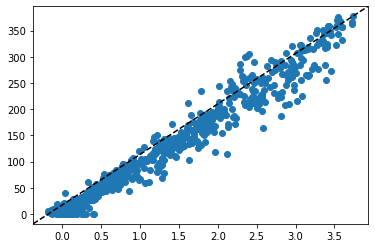

In [106]:
plt.scatter(mu12_3,100*y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()

In [107]:
var12_3 = np.diagonal(cov12_3)

In [108]:
mu12_3.shape

(1000, 1)

In [109]:
var12_3.shape

(1000,)

In [110]:
var12_3=np.array(var12_3).reshape(-1,1)

In [112]:
print(calculate_metrics(y_test, mu12_3, var12_3))

{'r2': 0.9636097083401028, 'rmse': 0.17928945842586028, 'mnll': -0.40708948916435483}
